# Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from pyomo.contrib.parmest import parmest
from pyomo.contrib.parmest.experiment import Experiment
from pyomo.contrib.doe import DesignOfExperiments
from pyomo.dae import ContinuousSet, DerivativeVar
import pandas as pd
import idaes

# Raw Model
This model and the code is provided by ***Shuvashish Mondal*** using the equations and data from *"Nonlinear Regression Analysis and Its Applications - 1988 - Bates" p.188. "Oil Shale: A Case Study"*


$$\frac{d\gamma_1}{dt} = -(\theta_1 + \theta_4) \gamma_1 $$
$$\frac{d\gamma_2}{dt} = \theta_1 \gamma_1 -(\theta_2 + \theta_3) \gamma_2 $$
$$\frac{d\gamma_3}{dt} = \theta_4 \gamma_1 + \theta_2 \gamma_2 $$

Here, $\gamma_1$ denotes kerogen, $\gamma_2$  bitumen, and $\gamma_3$ oil.
The model implies that kerogen decomposes to bitumen with rate constant $\theta_1$, and to oil with rate constant $\theta_4$, and that bitumen decomposes
to oil with rate constant $\theta_2$ and to unmeasured by-products with rate constant $\theta_3$

In my model, I will replace the following parameters with:  
    $\qquad Kerogen\; concentration, \; \gamma_1 \rightarrow G1$  
    $\qquad Bitumen \; concentration, \; \gamma_2 \rightarrow G2$  
    $\qquad Oil \; concentration, \; \gamma_3 \rightarrow G3$


# Data
Units of the data:  
$\qquad Temperature \rightarrow K$  
$\qquad Time \rightarrow min$  
$\qquad Bitumin \; Concentration \rightarrow \%$  
$\qquad Oil \; Concentration \rightarrow \%$  
  
Data at different temperatures:  

In [5]:
data_673K = {
    "Temperature": 673, # K
    "Time": [5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 120, 150],  # min
    "Bitumin_Concentration": [0, 2.2, 11.5, 13.7, 15.1, 17.3, 17.3, 20.1, 20.1, 22.3, 20.9, 11.5, 6.5, 3.6],  # %
    "Oil_Concentration": [0, 0, 0.7, 7.2, 11.5, 15.8, 20.9, 26.6, 32.4, 38.1, 43.2, 49.6, 51.8, 54.7]  # %
       }

data_698K = {
    "Temperature": 698,
    "Time": [5, 7, 10, 12.5, 15, 17.5, 20, 25, 30, 40, 50, 60],
    "Bitumin_Concentration": [6.5, 14.4, 18, 16.5, 29.5, 23.7, 36.7, 27.3, 16.5, 7.2, 3.6, 2.2],
    "Oil_Concentration": [0, 1.4, 10.8, 14.4, 21.6, 30.2, 33.1, 40.3, 47.5, 55.4, 56.8, 59.7]
}

data_723K = {
    "Temperature": 723,
    "Time": [5, 7.5, 8, 9, 10, 11, 12.5, 15, 17.5, 17.5, 20, 20],
    "Bitumin_Concentration": [8.6, 15.8, 25.9, 25.2, 26.6, 33.8, 25.9, 20.1, 12.9, 9.3, 3.6, 2.2],
    "Oil_Concentration": [0, 2.9, 16.5, 24.4, 29.5, 35.2, 39.5, 45.3, 43.1, 54.6, 59.7, 53.9]
}

data_748K = {
    "Temperature": 748,
    "Time": [3, 4.5, 5, 5.5, 6, 6.5, 7, 8, 9, 10, 12.5, 15],
    "Bitumin_Concentration": [0.7, 17.3, 23.0, 24.4, 23.0, 33.1, 31.6, 20.9, 10.1, 4.3, 0.7, 0.7],
    "Oil_Concentration": [0, 2.9, 17.3, 20.9, 25.9, 29.5, 33.8, 45.3, 53.2, 58.2, 57.5, 61.1]
}

data_773K = {
    "Temperature": 773,
    "Time": [3.0, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 10.0],
    "Bitumin_Concentration": [6.5, 24.4, 26.6, 25.9, 17.3, 21.6, 1.4, 0.0],
    "Oil_Concentration": [0.0, 23.0, 32.4, 37.4, 45.3, 45.3, 57.5, 60.4]
}

data_798K = {
    "Temperature": 798,
    "Time": [3.00, 3.25, 3.50, 4.00, 5.00, 7.00],
    "Bitumin_Concentration": [25.2, 33.1, 21.6, 20.9, 4.3, 0.0],
    "Oil_Concentration": [20.9, 25.2, 17.3, 36.7, 56.8, 61.8]
}

# Converting the data to ``pandas`` dataframe
data_673K = pd.DataFrame(data_673K)
data_698K = pd.DataFrame(data_698K)
data_723K = pd.DataFrame(data_723K)
data_748K = pd.DataFrame(data_748K)
data_773K = pd.DataFrame(data_773K)
data_798K = pd.DataFrame(data_798K)

In [8]:
# Let's check one of our dataframes
data_673K

,Temperature,Time,Bitumin_Concentration,Oil_Concentration
0,673,5,0.0,0.0
1,673,7,2.2,0.0
2,673,10,11.5,0.7
3,673,15,13.7,7.2
4,673,20,15.1,11.5
5,673,25,17.3,15.8
6,673,30,17.3,20.9
7,673,40,20.1,26.6
8,673,50,20.1,32.4
9,673,60,22.3,38.1


# Data Visualization
Let's visualize our data to see the pattern and have some initial thoughts about our data.

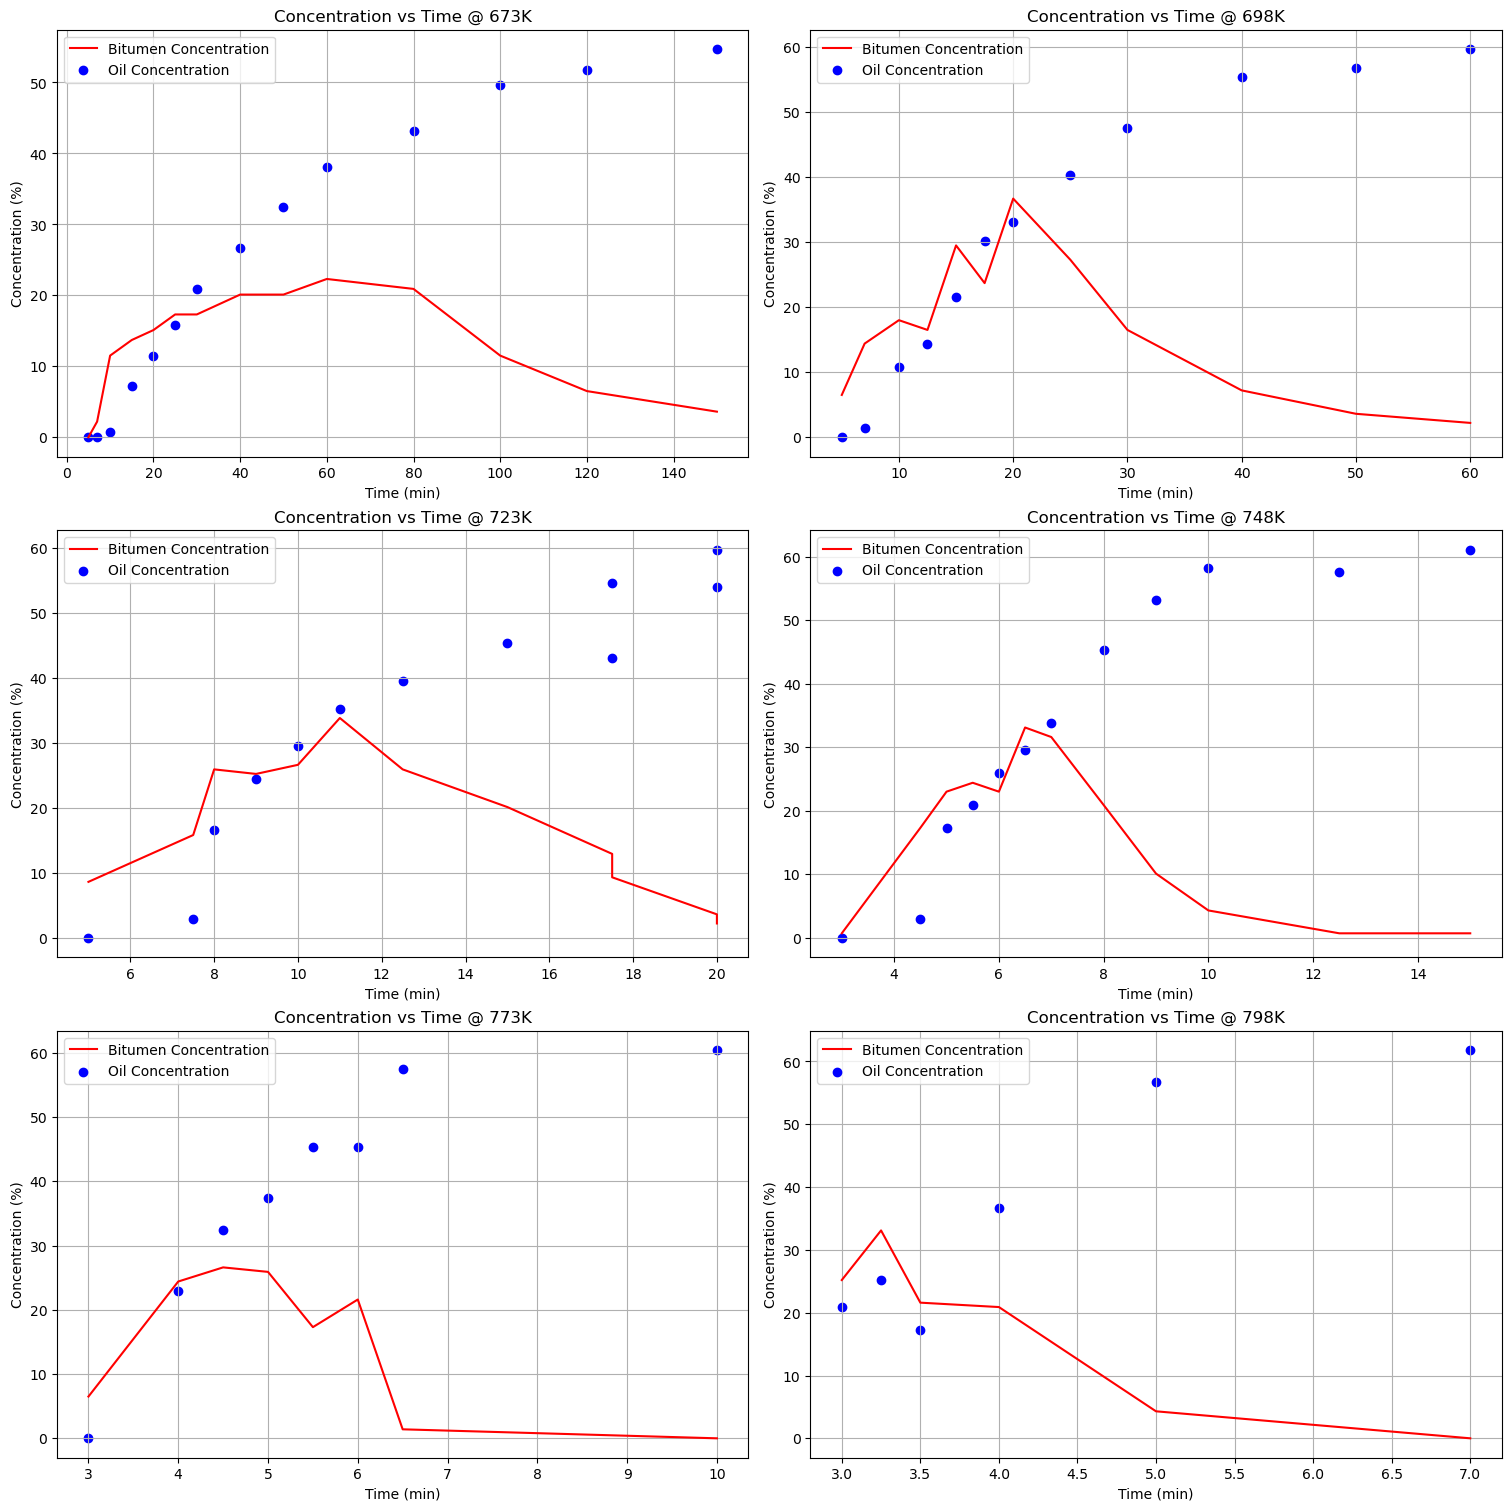

In [9]:
ind = "673K, 698K, 723K, 748K, 773K, 798K".split(",")
data_all = [data_673K, data_698K, data_723K, data_748K, data_773K, data_798K]

fig, axs = plt.subplots(3,2, figsize=(15, 15), constrained_layout=True)  # figsize is the size of the whole figure, not the size of each subplots

# Instead and copying and pasting the almost same code for all the plot, let's automate this with a nested for loop
# Flatten axs array for easier iteration
axs = axs.flatten()

# Loop through datasets and subplot axes simultaneously
for i, (ax, data, label) in enumerate(zip(axs, data_all, ind)):
    ax.plot(data['Time'], data["Bitumin_Concentration"], color="r", label="Bitumen Concentration")
    ax.scatter(data['Time'], data["Oil_Concentration"], color="b", label="Oil Concentration")
    ax.legend()
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Concentration (%)")
    ax.set_title(f"Concentration vs Time @ {label.strip()}")
    ax.grid()

# plt.show() # if running outside of jupyter notebook

In [10]:
# Initial Estimates of the parameters
"""
t0 = dead time, the time 
at t = t0 (dead time), G1 = 100. from this we can get the initial rate of the reaction and find the initial guess for the parameters, ``thetas``
"""
theta_10 = 0.031
theta_20 = 0.0131
theta_30 = 0.0286
theta_40 = 0.013

# Model / Class

In [11]:
class OilShale(Experiment):
    def __init__(self, data, t0=0, theta_initial=None, package=None, conc_err=3, nfe=20, ncp=3):
        """
        Arguments:
            data : experiment data, 
                type: pandas ``dataframe``
            t0: dead time (min). The time after which the reaction begins.
                default: 0
            theta_initial : initial estimate of our parameter values. 
                type: pandas ``dataframe``, or ``dict``
            package: the package for which we will use our `class`. if you use `doe`, use package="doe", otherwise use the default value.
                default: None. 
            conc_err : standard deviation of the concentration measurement error in our experiment. 
                default: 3%
            nfe : Number of finite elements for discretizing the model.
                default: 20
            ncp : Number of collocation points
                default: 3
        """
        self.data = data
        self.t0 = t0
        self.theta_initial = theta_initial
        self.package = package
        self.model = None
        self.nfe = nfe
        self.ncp = ncp
        self.conc_err = conc_err  # Error in concentration measurement
        self.dead_time = 6  # minutes
        
        # Setting the default value of ``theta_initial``
        if self.theta_initial is None:
            self.theta_initial = {
                "theta_10": 0.031,
                "theta_20": 0.0131,
                "theta_30" : 0.0286,
                "theta_40" : 0.013
            }

    # Creating the ``get_labeled_model``
    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.finalize_model()
            self.label_model()
            
        return self.model

                
    #++++++++++++++++++++++++++++++++++++++
    #  defining `create_model`
    def create_model(self):
        """
        Here, we will create different variables, parameters, and constraints
        """            
        m = self.model = pyo.ConcreteModel()

        # We will incorporote `dead time` (similar to time delay) and define a new time 
        self.time = self.data["Time"].apply(lambda x: (x - self.t0) if x > self.t0 else 0)

        # Set (time)
        m.t = ContinuousSet(initialize=sorted(set([0, 150] + list(self.time))))
        # we are initializing with the time from our data to make sure these time points are included when the model is discretized.
        # we added the python builtin func ``set`` to include the initial point (time = 0), which we will need when specifing intial conditions

        # Adjust the time
        
        # Parameters
        m.theta_1 = pyo.Var(bounds=(0, 1), initialize= self.theta_initial["theta_10"])
        m.theta_2 = pyo.Var(bounds=(0, 1), initialize= self.theta_initial["theta_20"])
        m.theta_3 = pyo.Var(bounds=(0, 1), initialize= self.theta_initial["theta_30"])
        m.theta_4 = pyo.Var(bounds=(0, 1), initialize= self.theta_initial["theta_40"])

        # State Variables
        m.G1 = pyo.Var(m.t, domain=pyo.NonNegativeReals, initialize=1e-6)  # kerogen concentration, gamma_1
        m.G2 = pyo.Var(m.t, domain=pyo.NonNegativeReals, initialize=1e-6)  # Bitumen concentration, gamma_2
        m.G3 = pyo.Var(m.t, domain=pyo.NonNegativeReals, initialize=1e-6)  # Oil concentration, gamma_3

        # Differential variables
        m.dG1dt = DerivativeVar(m.G1, wrt=m.t)
        m.dG2dt = DerivativeVar(m.G2, wrt=m.t)
        m.dG3dt = DerivativeVar(m.G3, wrt=m.t)

        # Constraints
        @m.Constraint(m.t)
        def kerogen_consum_rate(m, t):   # kerogen consumption rate
            return m.dG1dt[t] == -(m.theta_1 + m.theta_4) * m.G1[t]

        @m.Constraint(m.t)
        def bitumen_rxn_rate(m, t):  # Bitumen reaction rate. 
            return m.dG2dt[t] == m.theta_1 * m.G1[t] - (m.theta_2 + m.theta_3) * m.G2[t]

        @m.Constraint(m.t)
        def oil_gen_rate(m, t):  # oil generation rate
            return m.dG3dt[t] == m.theta_4 * m.G1[t] + m.theta_2 * m.G2[t]
        
        # m.pprint()  # preprint 
    
        return m

        
    #++++++++++++++++++++++++++++++++++++++
    def finalize_model(self):
        """
        Finalizing the model. Here, we will set the experimental conditions (e.g, initial conditions, boundary conditions),
        fixing the parameter values (if needed), update `t` values, and discretize the model (if model is dynamic). 
        It makes a solvable model.
        """
        m = self.model

        # fixing the parameter values
        m.theta_1.fix(self.theta_initial["theta_10"])
        m.theta_2.fix(self.theta_initial["theta_20"])
        m.theta_3.fix(self.theta_initial["theta_30"])
        m.theta_4.fix(self.theta_initial["theta_40"])

        # Setting the initial condition of the variables
        m.G1[0].fix(100)  # initial concentration of kerogen = 100%
        m.G2[0].fix(0)  # initial concentration of bitumen = 0%
        m.G3[0].fix(0)  # initial concentration of oil = 0%

        # Discretizing the model
        discr = pyo.TransformationFactory("dae.collocation")
        discr.apply_to(m, nfe=self.nfe, ncp=self.ncp, wrt=m.t)

        return m

    
    #++++++++++++++++++++++++++++++++++++++
    def label_model(self):
        """
        The model is updated with experimental outputs, inputs, errors and unknown parameters
        This makes the model labeled with full experiment
        """
        m = self.model

        
        # Experimental outputs
        m.experiment_outputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        if self.package == "doe":  #"""is it the standard way of doing this???????????????????????????????????????????????????"""
            m.experiment_outputs.update([(m.G1[t], None) for ind, t in enumerate(self.time)])            
        # Since we don't know the values of output `G1` at different `t`, we won't define that. B/c if we define that, 
        # `parmest` will try to compare that values with our actual data to calculate `SSE`. but since we don't have the actual data from `G1` it will show an error. 
        # However, `doe` needs m.G1
        m.experiment_outputs.update((m.G2[t], self.data.iloc[ind]["Bitumin_Concentration"]) for ind, t in enumerate(self.time))
        m.experiment_outputs.update((m.G3[t], self.data.iloc[ind]["Oil_Concentration"]) for ind, t in enumerate(self.time))
        
        # Experimental inputs
        m.experiment_inputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.experiment_inputs[m.G1[m.t.first()]] = None  # we have already set the input as ``m.G1[0].fix(100)``. 
        # and we won't set it again. you can also set any value here instead of ``None``, and the result will be the same. 
        # So, it doesn't care about this value

        # Experimental Measurement Error
        m.measurement_error = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.measurement_error.update((m.G1[t], self.conc_err) for t in self.time)
        m.measurement_error.update((m.G2[t], self.conc_err) for t in self.time)
        m.measurement_error.update((m.G3[t], self.conc_err) for t in self.time)
        

        # Unknown parameters
        m.unknown_parameters = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.unknown_parameters.update((k, pyo.value(k)) for k in [m.theta_1, m.theta_2, m.theta_3, m.theta_4])
        # m.unknown_parameters[m.theta_1] = m.theta_1.value
        # m.unknown_parameters[m.theta_2] = m.theta_2.value
        # m.unknown_parameters[m.theta_3] = m.theta_3.value
        # m.unknown_parameters[m.theta_4] = m.theta_4.value        
        # m.unknown_parameters.update((k, pyo.ComponentUID(k)) for k in [m.theta_1, m.theta_2, m.theta_3, m.theta_4])
        # All three syntax styles can be used here.

        return m    
    #++++++++++++++++++++++++++++++++++++++
        

# Parmest Example

## Parmest for single experiment

In [12]:
# Oil shale experiment object
oil_shale_exp = OilShale(data_673K)

# Creating an Estimator object
# pest = parmest.Estimator([oil_shale_exp])
pest = parmest.Estimator([oil_shale_exp], obj_function="SSE")   # pass the experiment as a ``list``
obj, theta = pest.theta_est()

# Ordering the theta values b/c output from parmest is not always ordered.
t_order = ["theta_1", "theta_2", "theta_3", "theta_4"]
theta_o = theta.loc[t_order]

# print the objective value and parameter values
print("\nSSE at optimal theta:", obj)
print(f"\nThe parameter values are:\n{theta_o}")


SSE at optimal theta: 223.89423466802907

The parameter values are:
theta_1    0.012708
theta_2    0.012539
theta_3    0.015147
theta_4    0.006429
dtype: float64


## Parmest for all the experiments

In [13]:
data_all = [data_673K, data_698K, data_723K, data_748K, data_773K, data_798K]  # making a list of all df
ind = "673K, 698K, 723K, 748K, 773K, 798K".split(",")  # we will make this the index of a concatenated df
n = len(data_all)
df_list = []
for i in range(n):
    # Oil shale experiment object
    oil_shale_exp = OilShale(data_all[i])
    
    # Creating an Estimator object
    # pest = parmest.Estimator([oil_shale_exp])
    pest = parmest.Estimator([oil_shale_exp], obj_function="SSE")   # pass the experiment as a ``list``
    obj, theta = pest.theta_est()
    
    # Ordering the theta values b/c output from parmest is not always ordered.
    t_order = ["theta_1", "theta_2", "theta_3", "theta_4"]
    theta_p = theta.loc[t_order]

    # Converting pd series to pd df
    df1 = pd.DataFrame(theta_p).T

    # adding the column "Temperature" and assigning string data
    df1["Temperature"] = ind[i]
    df1["SSE value"] = obj

    # appending the df
    df_list.append(df1)

# Concatenating all the dfs and setting the "Temperature" column to be the index.
df = pd.concat(df_list, ignore_index=True).set_index("Temperature")    
    
print(df)

              theta_1   theta_2   theta_3   theta_4    SSE value
Temperature                                                     
673K         0.012708  0.012539  0.015147  0.006429   223.894235
 698K        0.044278  0.057286  0.029039  0.006550   681.876312
 723K        0.376253  0.091175  0.122006  0.000000  3538.249678
 748K        0.119996  0.293621  0.036645  0.000000  1718.194556
 773K        0.178285  0.447148  0.061405  0.000000  1168.521454
 798K        0.309165  0.455922  0.168038  0.000000   780.680311


## Parmest, including dead time, $t_0$
Dead time is basically the time at when reaction starts. It's somewhat similar to time delay that exists in different control systems. Reaction in this example does not start at t=0. 
Let's estimate the parameters including dead time at 673K
### Single temperature

In [14]:
"""
let's try different ``dead_time`` range to minimize the SSE value. 
1st try: (0,10)
2nd try: (4, 6)
3rd try: (5.2, 5.4)
you can try (0,10) with larger numper of interior points. e.g., np.linspace(0, 10, 100)
"""
dead_time = np.linspace(5.2, 5.4, 11)
df_list = []
for i, t_d in enumerate(dead_time):
    # Oil shale experiment object
    oil_shale_exp = OilShale(data_673K, t0=t_d)
    
    # Creating an Estimator object
    # pest = parmest.Estimator([oil_shale_exp])
    pest = parmest.Estimator([oil_shale_exp], obj_function="SSE")   # pass the experiment as a ``list``
    obj, theta = pest.theta_est()
    
    # Ordering the theta values b/c output from parmest is not always ordered.
    t_order = ["theta_1", "theta_2", "theta_3", "theta_4"]
    theta_p = theta.loc[t_order]
    
    # Converting pd series to pd df
    df2 = pd.DataFrame(theta_p).T

    # adding the column "SSE value" and assigning `obj` value
    df2["SSE value"] = obj

    # appending the df
    df_list.append(df2)

# Concatenating all the dfs and setting the "Temperature" column to be the index.
df_dt = pd.concat(df_list, ignore_index=True) #, ignore_index=True).set_index("Temperature")    
# adding `dead time` as a new df column
df_dt["dead time"] = dead_time
# reordering the dataframe
df_dt = df_dt[['dead time','theta_1', 'theta_2', 'theta_3', 'theta_4', 'SSE value']]

# Let's print the parameter values for which ``SSE value`` is minimum
print(df_dt[df_dt["SSE value"] == df_dt["SSE value"].min()])
print("\n")
df_dt

   dead time   theta_1   theta_2   theta_3   theta_4  SSE value
3       5.26  0.015658  0.009941  0.018427  0.009027  98.674706




,dead time,theta_1,theta_2,theta_3,theta_4,SSE value
0,5.20,0.015627,0.009973,0.018395,0.008993,98.691475
1,5.22,0.015638,0.009962,0.018405,0.009004,98.681847
2,5.24,0.015648,0.009952,0.018416,0.009016,98.676248
3,5.26,0.015658,0.009941,0.018427,0.009027,98.674706
4,5.28,0.015669,0.009930,0.018437,0.009039,98.677248
5,5.30,0.015679,0.009920,0.018448,0.009050,98.683903
6,5.32,0.015689,0.009909,0.018458,0.009062,98.694699
7,5.34,0.015700,0.009898,0.018469,0.009073,98.709663
8,5.36,0.015710,0.009888,0.018480,0.009085,98.728825
9,5.38,0.015720,0.009877,0.018490,0.009096,98.752213


### At all temperatures
We can see quite some difference between the parameter values with and without dead time. Now let's calculate dead time for all the temperatures

In [16]:
data_all = [data_673K, data_698K, data_723K, data_748K, data_773K, data_798K]
T_value = "673K, 698K, 723K, 748K, 773K, 798K".split(",")
dead_time = np.linspace(0, 6, 20)
df_sse_min = []
for j, data in enumerate(data_all):
    df_list = []
    
    for i, t_d in enumerate(dead_time):
        # Oil shale experiment object
        oil_shale_exp = OilShale(data, t0=t_d)
        
        # Creating an Estimator object
        pest = parmest.Estimator([oil_shale_exp], obj_function="SSE")   # pass the experiment as a ``list``
        obj, theta = pest.theta_est()
        
        # Ordering the theta values b/c output from parmest is not always ordered.
        t_order = ["theta_1", "theta_2", "theta_3", "theta_4"]
        theta_p = theta.loc[t_order]
        
        # Converting pd series to pd df
        df2 = pd.DataFrame(theta_p).T
    
        # adding the column "SSE value" and assigning `obj` value
        df2["SSE value"] = obj
    
        # appending the df
        df_list.append(df2)

    # Concatenating all the dfs and setting the "Temperature" column to be the index.
    df_dt = pd.concat(df_list, ignore_index=True) #, ignore_index=True).set_index("Temperature")    
    # adding `dead time` as a new df column
    df_dt["dead time"] = dead_time
    df_sse_min.append(df_dt[df_dt["SSE value"] == df_dt["SSE value"].min()])
    
# Concatenating the list of dataframes into a dataframe
df_sse_min = pd.concat(df_sse_min, ignore_index=True)

# Reordering the DF
df_sse_min = df_sse_min[['dead time','theta_1', 'theta_2', 'theta_3', 'theta_4', 'SSE value']]
# Adding temperature as a DF column
df_sse_min["Temperature"] = T_value
# Setting "Temperature" as the index column
df_sse_min.set_index("Temperature")

model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations
      Exceeded.
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations
      Exceeded.


,dead time,theta_1,theta_2,theta_3,theta_4,SSE value
Temperature,,,,,,
673K,5.368421,0.015714,0.009883,0.018484,0.009090,98.738156
698K,4.421053,0.062253,0.046234,0.041781,0.018680,328.373858
723K,6.000000,0.202092,0.107292,0.132751,0.078431,294.697589
748K,3.157895,0.282955,0.398099,0.175332,0.015192,503.280740
773K,1.894737,0.285834,0.672757,0.142620,0.004462,755.358221
798K,1.894737,0.568570,0.950453,0.390500,0.000000,375.592073


# Temperature dependence
Now, we will see the temperature dependence using our previous calculation of parameters, $\theta$, at different temperature and then use `scipy` linregress to find the rate constant parameters from Arhenious equation.  

Arrhenius equation:
$$ lnk_i(T) = lnk_i(T_0) - \frac{E_i}{R} \left(\frac{1}{T} - \frac{1}{T_0} \right) $$

In [17]:
from scipy.stats import linregress

/opt/miniconda3/envs/idaes-env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/idaes-env/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2888: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


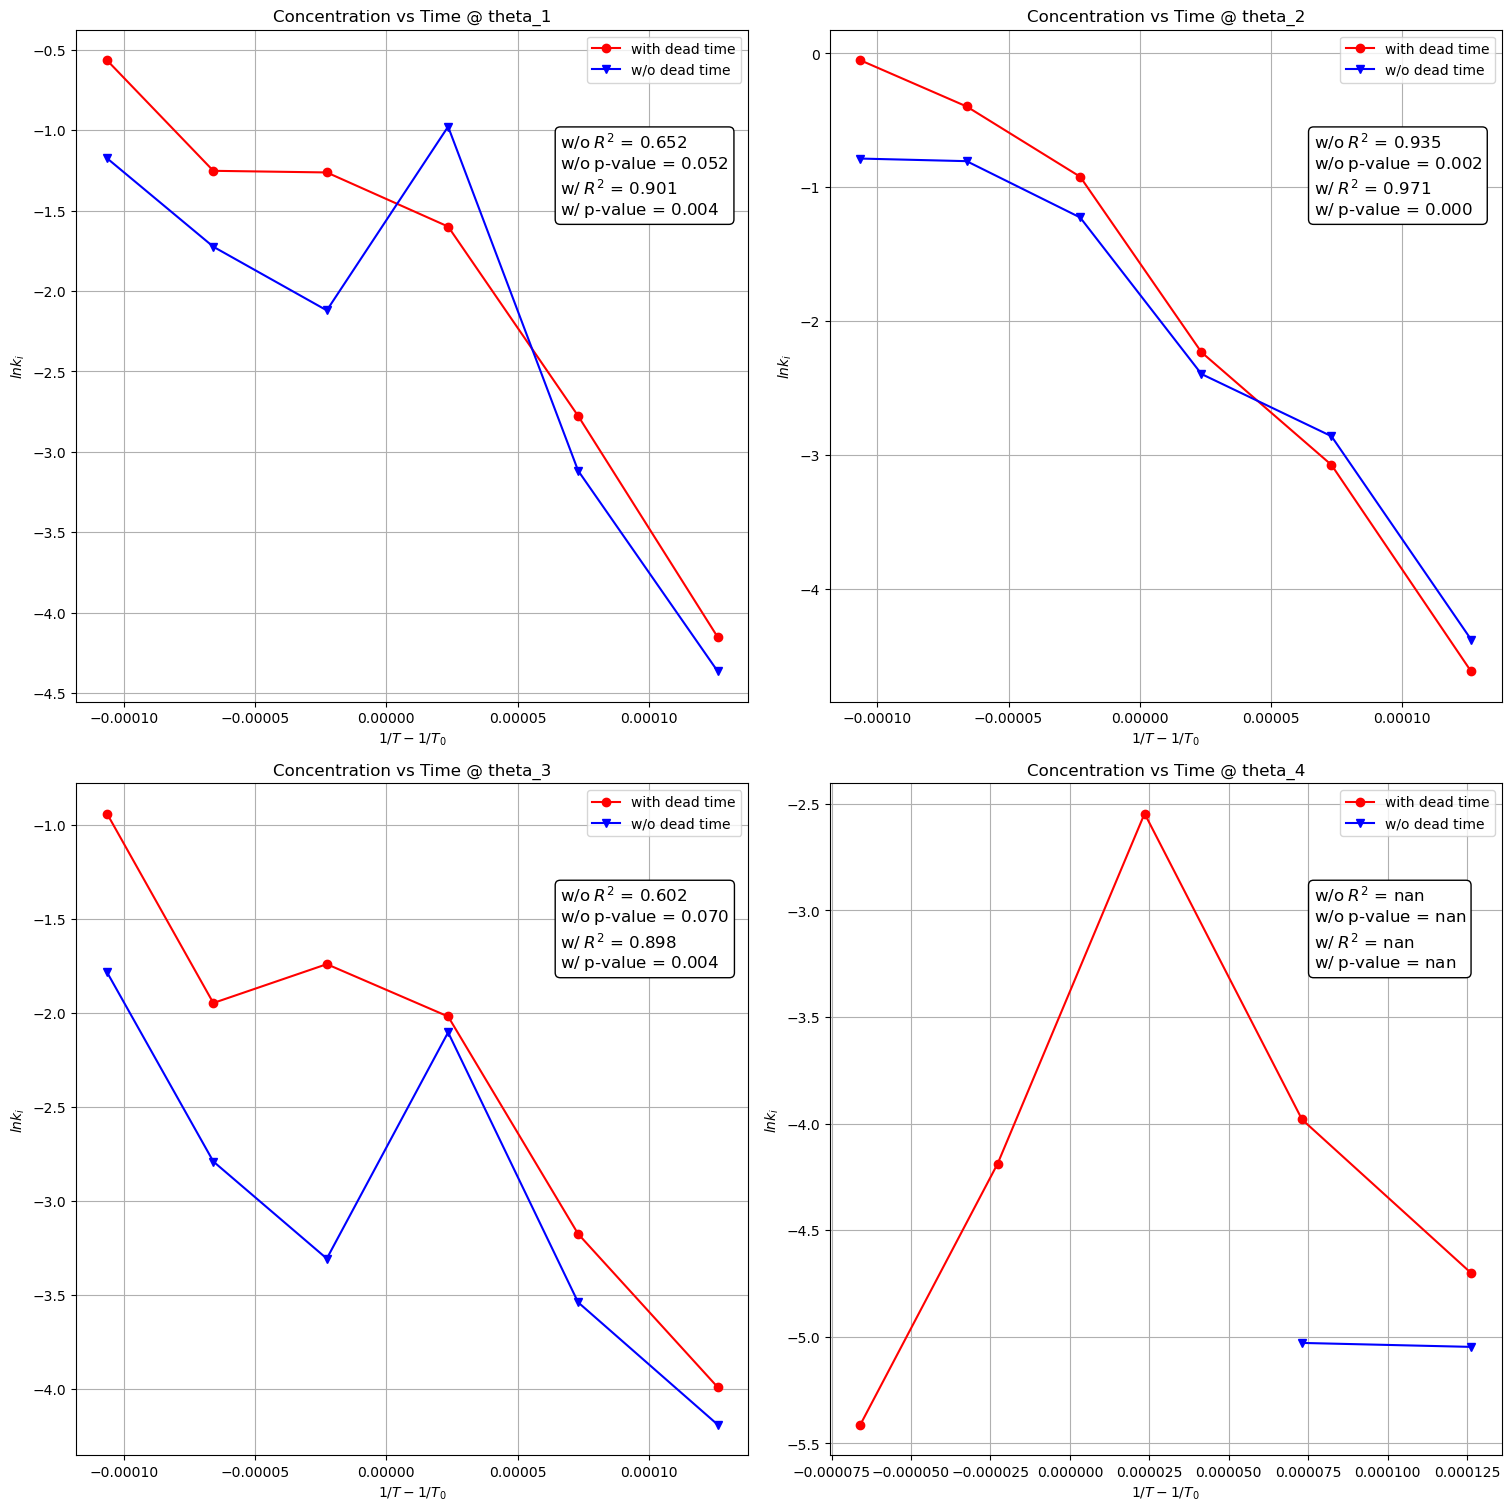

In [21]:
fig, axs = plt.subplots(2,2, figsize=(15, 15), constrained_layout=True)  # figsize is the size of the whole figure, not the size of each subplots

# Instead and copying and pasting the almost same code for all the plot, let's automate this with a nested for loop
# Flatten axs array for easier iteration
axs = axs.flatten()

parameters = ['theta_1', 'theta_2', 'theta_3', 'theta_4']

# Universal gas constant ``R``
Rg = 8.31446261815324  # J/K-mole

T_val = [int(T[:-1]) for T in df_sse_min["Temperature"]]  # extract the temperature values from the DF
T0 = np.mean(T_val)  # let's take the mean temperature as T0
x = 1/np.array(T_val) - 1/T0
# Loop through datasets and subplot axes simultaneously
for i, (para, ax) in enumerate(zip(parameters, axs)):
    ax.plot(x, np.log(df_sse_min[para]), "-ro", label="with dead time")
    ax.plot(x, np.log(df[para]), "-bv", label="w/o dead time")
    ax.set_xlabel("$1/T - 1/T_0$")
    ax.set_ylabel("$lnk_i$")
    ax.set_title(f"Concentration vs Time @ {para}")
    ax.legend()
    ax.grid()
    slope, intercept, R_value, p_value, std_err = linregress(x, np.log(df_sse_min[para]))
    slope1, intercept1, R_value1, p_value1, std_err1 = linregress(x, np.log(df[para]))
    
    # # Activation energy
    # Ea = - slope * Rg
    
    # # Rate constant and R^2 value
    # k0 = np.exp(intercept)
    R_squared =  R_value ** 2
    R_squared1 =  R_value1 ** 2
    
    # Display calculated values on the plot
    textstr = (
        rf"$\text{{w/o}} \; R^2$ = {R_squared1:.3f}"+"\n"
        rf"$\text{{w/o}} \; \text{{p-value}}$ = {p_value1:.3f}"+"\n"
        rf"$\text{{w/}} \; R^2$ = {R_squared:.3f}"+"\n"
        rf"$\text{{w/}} \; \text{{p-value}}$ = {p_value:.3f}"
    )



    ax.annotate(textstr, xy=(0.72, 0.85), xycoords="axes fraction",
                fontsize=12, verticalalignment="top", bbox=dict(boxstyle="round,pad=0.3",
                                                                edgecolor="black", facecolor="white"))


# plt.show() # if running outside of jupyter notebook

Since some of the values of $\theta_4$ is 0 , so we run into a `RuntimeWarnig` as log(0) undefined. Overall, we got better result while considering dead time, although not quite good to claim the data to fit a straight line.

# DOE Example

In [26]:
def run_reacton_doe(data):
    """
    Argument:
    data: experiment data to pass to Design of experiments. type: pandas dataframe
    """
    experiment = OilShale(data, package='doe')

    doe_obj = DesignOfExperiments(
        experiment, 
        tee=True
    )

    FIM = doe_obj.compute_FIM()  
    return FIM

In [27]:
FIM = run_reacton_doe(data_673K) 
print('The FIM for the experiment is: ')
print(FIM)

The FIM for the experiment is: 
[[ 2384505.40673542 -1046889.41564668   -31885.18432516   313457.8428493 ]
 [-1046889.41564668  3104596.16512702  -465551.8077583   4071557.60221659]
 [  -31885.18432516  -465551.8077583    691324.02002369  -645670.42640477]
 [  313457.8428493   4071557.60221659  -645670.42640477  7993078.62044471]]
